In [1]:
import warnings
warnings.simplefilter('ignore')
import tensorflow as tf

In [2]:
print("Is GPU available?", tf.test.is_gpu_available())
print("TF version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available? True
TF version: 2.3.1
Keras version: 2.4.0


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE

from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import random
import gym

In [4]:
class Critic(tf.keras.Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.f1 = tf.keras.layers.Dense(512, activation='relu')
        self.f2 = tf.keras.layers.Dense(512, activation='relu')
        self.v =  tf.keras.layers.Dense(1, activation=None)

    def call(self, inputstate, action):
        x = self.f1(tf.concat([inputstate, action], axis=1))
        x = self.f2(x)
        x = self.v(x)
        return x


class Actor(tf.keras.Model):
    def __init__(self, no_action):
        super(Actor, self).__init__()    
        self.f1 = tf.keras.layers.Dense(512, activation='relu')
        self.f2 = tf.keras.layers.Dense(512, activation='relu')
        self.mu =  tf.keras.layers.Dense(no_action, activation='tanh')

    def call(self, state):
        x = self.f1(state)
        x = self.f2(x)
        x = self.mu(x)  
        return x

In [5]:
class Agent():
    def __init__(self, n_actions, min_action, max_action):
        self.actor = Actor(n_actions)
        self.critic = Critic()
        self.actor_target = Actor(n_actions)
        self.critic_target = Critic()
        self.batch_size = 64
        self.n_actions = n_actions
        self.actor_opt = Adam(1e-4)
        self.critic_opt = Adam(1e-4)
        self.memory = deque(maxlen=100000)
        self.steps = 0
        self.replace = 5
        self.gamma = 0.99
        self.min_action = min_action
        self.max_action = max_action
        self.tau = 0.005
        self.actor_target.compile(optimizer=self.actor_opt)
        self.critic_target.compile(optimizer=self.critic_opt)
    
    def store(self, state, action, reward, n_state, done):
        pack = [state, action, reward, n_state, 1 - int(done)]
        self.memory.append(pack)
    
    def take_data(self, batch_size):
        pack = random.sample(self.memory, batch_size)
        states = []
        actions = []
        rewards = []
        n_states = []
        dones = []
        for i in range(batch_size):
            states.append(pack[i][0])
            actions.append(pack[i][1])
            rewards.append(pack[i][2])
            n_states.append(pack[i][3])
            dones.append(pack[i][4])
        return states, actions, rewards, n_states, dones


    def act(self, state, evaluate=False):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        actions = self.actor(state)
        if not evaluate:
            actions += tf.random.normal(shape=[self.n_actions], mean=0.0, stddev=0.1)

        actions = self.max_action * (tf.clip_by_value(actions, self.min_action, self.max_action))
        return actions[0]
    
    def update_target(self, tau=None):
        if tau is None:
            tau = self.tau

        weights1 = []
        targets1 = self.actor_target.weights
        for i, weight in enumerate(self.actor.weights):
            weights1.append(weight * tau + targets1[i]*(1-tau))
        self.actor_target.set_weights(weights1)

        weights2 = []
        targets2 = self.critic_target.weights
        for i, weight in enumerate(self.critic.weights):
            weights2.append(weight * tau + targets2[i]*(1-tau))
        self.critic_target.set_weights(weights2)
    
    def upgrade(self):
        if len(self.memory) < 3*self.batch_size:
            return 

        states, actions, rewards, n_states, dones = self.take_data(self.batch_size)

        states = tf.convert_to_tensor(states, dtype= tf.float32)
        n_states = tf.convert_to_tensor(n_states, dtype= tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype= tf.float32)
        actions = tf.convert_to_tensor(actions, dtype= tf.float32)

        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:

            target_actions = self.actor_target(n_states)
            target_n_state = tf.squeeze(self.critic_target(n_states, target_actions), 1)
            critic_value = tf.squeeze(self.critic(states, actions), 1)
            target_values = rewards + self.gamma * target_n_state * dones
            critic_loss = tf.keras.losses.MSE(target_values, critic_value)

            new_policy_actions = self.actor(states)
            actor_loss = -self.critic(states, new_policy_actions)
            actor_loss = tf.math.reduce_mean(actor_loss)

        grads1 = tape1.gradient(actor_loss, self.actor.trainable_variables)
        grads2 = tape2.gradient(critic_loss, self.critic.trainable_variables)
        self.actor_opt.apply_gradients(zip(grads1, self.actor.trainable_variables))
        self.critic_opt.apply_gradients(zip(grads2, self.critic.trainable_variables))
        
        self.update_target()

        self.steps +=1

In [6]:
env = gym.make('LunarLanderContinuous-v2')

print('Min_action:', env.action_space.low[0])
print('Max_action: ', env.action_space.high[0])
print('States: ', env.observation_space.shape)
print('Actions: ', env.action_space.shape)

Min_action: -1.0
Max_action:  1.0
States:  (8,)
Actions:  (2,)


In [7]:
agent = Agent(2, -1, 1)

n_episodes = 2000
avg_hist = []
scores = []

for i in range(n_episodes):
    score = 0 
    state = env.reset()
    done = False

    while not done:
        action = agent.act(state)
        n_state, reward, done, _ = env.step(action)
        agent.store(state, action, reward, n_state, done)
        agent.upgrade()
        state = n_state
        score += reward
    
    scores.append(score)
    avg_reward = int(np.mean(scores[-100:]))
    avg_hist.append(avg_reward)
    print(f'Episode: {i}  Score: {score}  AVG: {avg_reward}')
    
    if avg_reward >= 205:
        break

env.close()

Episode: 0  Score: -156.11498827680327  AVG: -156
Episode: 1  Score: -120.71003169679321  AVG: -138
Episode: 2  Score: -62.56118001061301  AVG: -113
Episode: 3  Score: -141.3660699005494  AVG: -120
Episode: 4  Score: -17.184340300992787  AVG: -99
Episode: 5  Score: -276.0279989181058  AVG: -128
Episode: 6  Score: -160.9576367159814  AVG: -133
Episode: 7  Score: -727.9078353637191  AVG: -207
Episode: 8  Score: -587.6036233530338  AVG: -250
Episode: 9  Score: -1049.742619785  AVG: -330
Episode: 10  Score: -381.4977791534423  AVG: -334
Episode: 11  Score: -599.685508052331  AVG: -356
Episode: 12  Score: -86.98694251758465  AVG: -336
Episode: 13  Score: -143.82818905579103  AVG: -322
Episode: 14  Score: -102.02180717950571  AVG: -307
Episode: 15  Score: -134.27875185143984  AVG: -296
Episode: 16  Score: -171.34525351946652  AVG: -289
Episode: 17  Score: -194.5095559569109  AVG: -284
Episode: 18  Score: -223.4554189771527  AVG: -280
Episode: 19  Score: -205.21595838310606  AVG: -277
Episode

Episode: 162  Score: -190.18098040978194  AVG: -196
Episode: 163  Score: -199.37258395190543  AVG: -197
Episode: 164  Score: -176.1463466454305  AVG: -197
Episode: 165  Score: -142.84177558630944  AVG: -194
Episode: 166  Score: -373.4193060238181  AVG: -197
Episode: 167  Score: -49.56261339131839  AVG: -194
Episode: 168  Score: -529.3618523390709  AVG: -199
Episode: 169  Score: -123.5325443701042  AVG: -196
Episode: 170  Score: -58.26370922166175  AVG: -196
Episode: 171  Score: -142.90830140344852  AVG: -195
Episode: 172  Score: -159.63446501441618  AVG: -194
Episode: 173  Score: -179.03027206578136  AVG: -193
Episode: 174  Score: -157.53462206342923  AVG: -192
Episode: 175  Score: -154.38221437568515  AVG: -192
Episode: 176  Score: -144.9647196162828  AVG: -193
Episode: 177  Score: -127.6414753775052  AVG: -192
Episode: 178  Score: -119.23832693565137  AVG: -192
Episode: 179  Score: -226.9985220135193  AVG: -193
Episode: 180  Score: -76.15308582069753  AVG: -190
Episode: 181  Score: -

Episode: 322  Score: -38.71561453453554  AVG: -103
Episode: 323  Score: -92.6305376902314  AVG: -103
Episode: 324  Score: -91.76575719347971  AVG: -102
Episode: 325  Score: -120.18532987553316  AVG: -103
Episode: 326  Score: -63.69347114930514  AVG: -103
Episode: 327  Score: -65.57377497724792  AVG: -103
Episode: 328  Score: -92.31702302044609  AVG: -103
Episode: 329  Score: -78.12601967242816  AVG: -104
Episode: 330  Score: -104.93541311064789  AVG: -103
Episode: 331  Score: -4.562858424998083  AVG: -102
Episode: 332  Score: -167.1234521548824  AVG: -103
Episode: 333  Score: -147.68444990663124  AVG: -104
Episode: 334  Score: -185.47989255943355  AVG: -105
Episode: 335  Score: -159.32343701724292  AVG: -106
Episode: 336  Score: -125.49591460112062  AVG: -106
Episode: 337  Score: -13.254967041416705  AVG: -102
Episode: 338  Score: -173.73787750000838  AVG: -103
Episode: 339  Score: -104.74940798682447  AVG: -104
Episode: 340  Score: -164.6178184519741  AVG: -105
Episode: 341  Score: -2

Episode: 484  Score: -179.98122112715203  AVG: -37
Episode: 485  Score: 197.06822348388835  AVG: -34
Episode: 486  Score: -205.3195492748577  AVG: -37
Episode: 487  Score: 90.99908108074936  AVG: -35
Episode: 488  Score: 220.0450431248531  AVG: -32
Episode: 489  Score: 241.1257707652706  AVG: -29
Episode: 490  Score: -198.4817608185358  AVG: -30
Episode: 491  Score: 237.2517855564217  AVG: -28
Episode: 492  Score: 218.69478431604216  AVG: -25
Episode: 493  Score: 224.82475528525853  AVG: -22
Episode: 494  Score: 38.35271118442671  AVG: -21
Episode: 495  Score: 262.5847793990181  AVG: -18
Episode: 496  Score: 252.65971285019208  AVG: -15
Episode: 497  Score: 255.18953789673694  AVG: -11
Episode: 498  Score: 275.6330598882855  AVG: -8
Episode: 499  Score: 250.8599175752594  AVG: -5
Episode: 500  Score: 258.36974376380124  AVG: -2
Episode: 501  Score: 260.83560421641783  AVG: 0
Episode: 502  Score: 258.65182466220904  AVG: 2
Episode: 503  Score: 258.09015234981575  AVG: 6
Episode: 504  Sc

Episode: 650  Score: 267.4132169648087  AVG: 152
Episode: 651  Score: 246.4260416859865  AVG: 153
Episode: 652  Score: 258.83527297277794  AVG: 153
Episode: 653  Score: 279.6427553067724  AVG: 153
Episode: 654  Score: 233.21973099401902  AVG: 153
Episode: 655  Score: 243.4129802304611  AVG: 153
Episode: 656  Score: 260.6205199122271  AVG: 154
Episode: 657  Score: 236.28067046263837  AVG: 153
Episode: 658  Score: 73.64633710489286  AVG: 156
Episode: 659  Score: 256.12643756437376  AVG: 157
Episode: 660  Score: 239.22172895029092  AVG: 157
Episode: 661  Score: 222.31170031350294  AVG: 161
Episode: 662  Score: 157.63116802364556  AVG: 160
Episode: 663  Score: -120.99096427204525  AVG: 156
Episode: 664  Score: 220.50008088256425  AVG: 160
Episode: 665  Score: 282.0490883144287  AVG: 161
Episode: 666  Score: 263.7752833917041  AVG: 161
Episode: 667  Score: 263.74641302985697  AVG: 161
Episode: 668  Score: 244.25175266976666  AVG: 161
Episode: 669  Score: 275.6766560709484  AVG: 160
Episode:

Text(0, 0.5, 'Avg rewards')

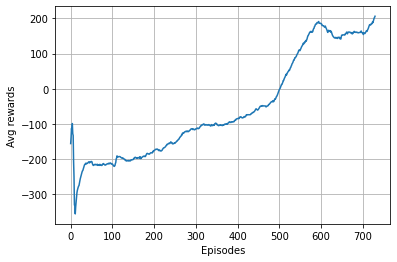

In [8]:
plt.plot(avg_hist)
plt.grid()
plt.xlabel('Episodes')
plt.ylabel('Avg rewards')

In [10]:
env = gym.make('LunarLanderContinuous-v2')

for i in range(10):
    state = env.reset()
    done = False
    
    while not done:
        action = agent.act(state, True)
        n_state, _, done, _ = env.step(action)
        state = n_state
        env.render()
env.close()

In [11]:
agent.actor.save_weights('actor_weights.h5')